In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense, Flatten


In [ ]:
# Load dataset
file_path = '/content/yahoo_data.xlsx'
df = pd.read_excel(file_path)

In [ ]:
# Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')  # Ensure data is ordered by date
features = ['Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [ ]:
# Convert to sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length, 3])  # Predict 'Close*' column
    return np.array(sequences), np.array(labels)

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)
X = X.reshape((X.shape[0], seq_length, 1, len(features), 1))  # ConvLSTM input shape

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# ConvLSTM Model
model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1, len(features)), input_shape=(seq_length, 1, len(features), 1), activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)  # Predicting a single value (Close*)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 1, 1, 64)            │         100,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           3,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,397 (403.89 KB)

 Trainable params: 103,397 (403.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1255 - mae: 0.2633 - val_loss: 0.0022 - val_mae: 0.0340
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0020 - mae: 0.0308 - val_loss: 0.0013 - val_mae: 0.0230
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011 - mae: 0.0238 - val_loss: 9.0082e-04 - val_mae: 0.0202
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.4442e-04 - mae: 0.0223 - val_loss: 9.1281e-04 - val_mae: 0.0230
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.5572e-04 - mae: 0.0204 - val_loss: 8.1694e-04 - val_mae: 0.0215
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.1166e-04 - mae: 0.0229 - val_loss: 8.7467e-04 - val_mae: 0.0202
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 8.7627e-04 - mae: 0.0225 - val_loss: 8.5943e-04 - val_mae: 0.0231
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.7822e-04 - mae: 0.0224 - val_loss: 6.6258e-04 - val_mae: 0.0178
Epoch 9/20
63/63 ━━━

In [ ]:
# Evaluation
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3414e-04 - mae: 0.0160 
Test Loss: 0.00045505465823225677, Test MAE: 0.015298819169402122


In [ ]:
# Predictions
y_pred = model.predict(X_test)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [ ]:
# Rescale predictions and ground truth
y_pred_rescaled = scaler.inverse_transform([[0, 0, 0, y, 0, 0] for y in y_pred.ravel()])[:, 3]
y_test_rescaled = scaler.inverse_transform([[0, 0, 0, y, 0, 0] for y in y_test])[:, 3]

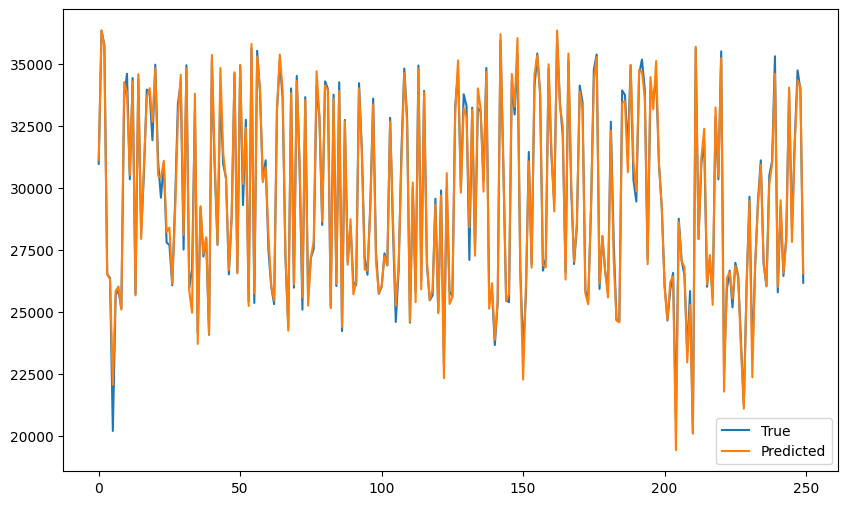

In [ ]:
# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.show()
